<a href="https://colab.research.google.com/github/hjjimmykim/SchwabRoyale/blob/master/SchwabRoyale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Schwab Royale

In the beginning there was darkness.
Then there was David.

# Libraries

In [55]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import time
import copy

from collections import deque

import tensorflow as tf


#from graphics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [0]:
# Agent parameters
K = 4           # Number of teams
N = 4           # Number of agents per team
hp_start = 2    # Starting hp
action_size = 4 # Four cardinal directions

# Simulation parameters
M = 32    # Width of map
max_turn = 10000 # Maximum number of turns
n_ep = 2  # Number of training episodes (games)

# Reinforcement learning parameters
batch_size = 100  # Batch size
memory_size = 10000 # Number of experiences agent can keep
hidden_dim = 100 # Hidden layer size

target_copy_freq = 10 # Update the target network every this many turns

alpha = 0.01 # Learning rate
beta = 0.1   # Exploitation parameter
gamma = 0.9  # Discount factor
sigma = 0.5  # Selfishness factor
Omega = N    # Final survivor bonus (should it be for team and/or self?)

#Spunk

Constantijn takes responsibility for the time wasted making this, however, Jimmy supported him.

In [0]:
death_messages = ["was wasted by",
                  "met a bitter end at the hands of",
                  "was swarmed by TensorBros sent by",
                  "was forced to press Alt+F4 by",
                  "was peer-reviewed by",
                  "got schwabbed by", # https://www.urbandictionary.com/define.php?term=Schwabbed
                  "was brutally neglected by",
                  "had his heart stolen by",
                  "slipped and fell while running from",
                  "became petrified by the sight of"
                 ]

def kill_log(killer, killer_team, victim, victim_team, turn):
  phrase = "%s [Team %i] " + np.random.choice(death_messages) + " %s [Team %i] on turn %i."
  return phrase % ("David "+str(victim), victim_team, "David "+str(killer), killer_team, turn)

# Neural Network

References:
*   https://web.stanford.edu/class/cs20si/2017/lectures/slides_14.pdf
*   https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Doom/Deep%20Q%20learning%20with%20Doom.ipynb



In [0]:
class Net:
  def __init__(self, input_dim, hidden_dim = 100, output_dim = 4):
    # Fully-connected feedforward network with 2 hidden layers    
    # input-dim = 1-D reshaped map + hp
    # hidden_dim = number of units per hidden layer
    # output_dim = number of outputs (i.e. actions)

    # Input placeholder
    self.inputs = tf.placeholder(tf.float32, shape=[None,input_dim], name="inputs")

    ## Weight initialization
    # input -> h1
    W0 = tf.Variable(tf.truncated_normal([input_dim,hidden_dim],stddev=0.1))
    b0 = tf.Variable(tf.constant(0.1,shape=[hidden_dim]))

    # h1 -> h2
    W1 = tf.Variable(tf.truncated_normal([hidden_dim,hidden_dim],stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1,shape=[hidden_dim]))
    
    # h2 -> output
    W2 = tf.Variable(tf.truncated_normal([hidden_dim,output_dim],stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1,shape=[output_dim]))
    
    
    ## Hidden layers
    h1 = tf.nn.relu(tf.matmul(self.inputs,W0) + b0)
    h2 = tf.nn.relu(tf.matmul(h1,W1) + b1)
    
    ## Output layer
    self.outputs = tf.matmul(h2,W2) + b2
    
    ## Keep track of parameters
    self.params = [W0,b0,W1,b1,W2,b2]
    
    
    #Learnability
    self.actions = tf.placeholder(tf.float32, shape=[None, action_size], name="actions")
    
    self.Q = tf.reduce_sum(tf.multiply(self.outputs, self.actions), axis=1)
    self.target_Q = tf.placeholder(tf.float32, [None])
    
    self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))    
    self.optimizer = tf.train.RMSPropOptimizer(alpha).minimize(self.loss)

Memory Class source: https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb

In [0]:
class Memory:
  def __init__(self, max_size):
    self.max = max_size
    self.buffer = deque(maxlen = max_size)    # "deque" = Double Ended QUEue
  
  # Add entry. FIFO.
  def add(self, experience):
    self.buffer.append(experience)
  
  # Sample batch_size number of entries, without replacement. Return as a list.
  def sample(self, batch_size):
    buffer_size = len(self.buffer)
    index = np.random.choice(np.arange(buffer_size),
                             size = batch_size,
                             replace = False)
    return [self.buffer[i] for i in index]
  
  # Own additions
  def is_full(self):
    return len(self.buffer) == self.max
  
  def wipe(self):
    self.buffer.clear() # NB, does not affect max length

  def length(self):
    return len(self.buffer)

### Stanford fancy memory alternative:

In [0]:
class ReplayBuffer:
  
  def __init__(self, template, capacity):
    self._capacity = capacity # Number of memories to maintain
    self._buffers = self._create_buffers(template)
    self._index = tf.Variable(0, dtype=tf.int32, trainable=False)
    
  # Number of memories saved
  def size(self):
    return tf.minimum(self._index, self._capacity)
  
  def append(self, tensors):
    position = tf.mod(self._index, self._capacity)
    with tf.control_dependencies([
        b[position].assign(t) for b, t in
        zip(self._buffers, tensors)]):
      return self._index.assign_add(1)
  
  def sample(self, amount):
    positions = tf.random_uniform((amount,), 0, self.size - 1, tf.int32)
    return [tf.gather(b, positions)
            for b in self._buffers]

  def _create_buffers(self, template):
    buffers = []
    for tensor in template:
      shape = tf.TensorShape([self._capacity]).concatenate(
          tensor.get_shape())
      initial = tf.zeros(shape, tensor.dtype)
      buffers.append(tf.Variable(
          initial, trainable=False))
    return buffers

# Agent

In [0]:
class Agent:
  def __init__(self, id, hp, loc, k, memory_size, tenure):
    self.id = id    # Agent id (in agent_dict)
    self.hp = hp    # Hit points
    self.loc = loc  # Location (x,y coordinate)
    self.team = k   # Team index (k = 1, ..., K), since 0 is self!
    self.memory_size = memory_size # Experience replay maximum capacity
    self.tenure = tenure       # If you don't have tenure yet, you gotta learn (i.e. determines whether the agent is learning)
    
    self.personal_reward = 0   # Keep track of personal reward    
    
    # Create brain
    input_dim = M*M + 1 # Map cells + hp
    output_dim = action_size
    
    self.DQN = Net(input_dim, hidden_dim, output_dim) # Personal neural network
    #self.DQN_target = copy.deepcopy(self.DQN)         # Target network
    
    self.memory = Memory(memory_size)
    
  
  # Checks living status
  def alive(self):
    return self.hp > 0
  
  
  # State formation
  def observe(self, map):
    state = copy.deepcopy(map)
    state[self.loc[0]][self.loc[1]] = 0            # Own location = 0 on map
    state = np.reshape(state, [1,-1]).squeeze()    # Convert to 1D array
    state = np.hstack([state, self.hp])            # Append hp
    return state
  '''
  # Takes a state, and returns an action from the action space
  def choose_action(self, state, sess):
    # Action selection (Q function) ------------------------------------------
    q_values = self.DQN(state) # Get q-values from the network
    p_values = tf.exp(beta * q_values)/tf.reduce_sum(tf.exp(beta * q_values)) # Boltzmann probabilities
    
    action = np.random.choice(np.arange(4),p=p_values.eval())
    return action
  '''
  
  # Taking an action based on chosen direction
  def act(self, dir, turn, quiet):    # dir should be an np.array
    # Rewards resulting from this move
    personal_point = 0
    team_point = 0
    
    target_loc = self.loc + dir # Candidate target location
    
    # Check if target location is within bounds and the agent actually moves
    if check_valid_loc(target_loc) and ~np.all(dir == [0,0]):
      
      target_ind = map[target_loc[0]][target_loc[1]]    # Object at target location
      
      if target_ind == -1:                              # If target location is empty
        map[self.loc[0],self.loc[1]] = -1               # Previous location becomes empty
        map[target_loc[0],target_loc[1]] = self.team    # Target location becomes occupied
        self.loc = target_loc                           # Update location
      else:                                             # If target location is occupied
        # Agent at target location
        target_id = find_agent(target_loc)
        target_agent = agent_dict[target_id]
        '''
        if not target_agent.alive(): # Target agent is already dead; this should not run
          print("David", self.id, "teabagged David", target_id)
        '''
        target_agent.hp -= 1                            # Deal damage

        if not target_agent.alive():                    # If target agent has been killed
          # Display kill log
          if not quiet:
            print(kill_log(self.id, self.team, target_id, target_agent.team, turn))

          target_agent.loc = [-1,-1]                    # Move corpse to the underworld

          map[self.loc[0],self.loc[1]] = -1             # Previous location becomes empty
          map[target_loc[0],target_loc[1]] = self.team  # Target location becomes occupied
          self.loc = target_loc                         # Update location
          
          personal_point += 1             # Gain a point for self
          if target_agent.team != self.team:
            team_point += 1               # Gain a point for the team, if the target was from another team
  
    # Update the cumulative rewards
    self.personal_reward += personal_point
    team_scores[self.team-1] += team_point
    
    # Return immediate rewards
    return personal_point, team_point

## Agent Testing

N.B.: Before testing agent features, run Initialize below

###Movement Testing

Test whether movement is recorded on the map properly, 
test agent's functions

In [0]:
initialize_map()
test_agent = agent_dict[0]

In [346]:
agent_dict

{0: <__main__.Agent at 0x7f42fdccefd0>,
 1: <__main__.Agent at 0x7f42fdcce668>,
 2: <__main__.Agent at 0x7f42fdc90940>,
 3: <__main__.Agent at 0x7f42fdc905c0>}

In [347]:
print(test_agent.loc)
test_agent.observe()

[0 0]


array([[ 0, -1,  1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [348]:
test_agent.move([1,1])
print(test_agent.loc)
test_agent.observe()

[1 1]


array([[-1, -1,  1, -1, -1],
       [-1,  0, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [349]:
test_agent.move([0,-1])
print(test_agent.loc)
test_agent.observe()

[1 0]


array([[-1, -1,  1, -1, -1],
       [ 0, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [350]:
test_agent.move([-1,0])
print(test_agent.loc)
test_agent.observe()

[0 0]


array([[ 0, -1,  1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [351]:
find_agent([0,0])

0

### Combat Testing

Test attacking (movement upon kill), HP tracking, death of a teammate (personal reward), and death of an enemy (personal and team reward)

In [0]:
initialize_map()
attack_agent = agent_dict[0]
gimp_agent = agent_dict[1]
enemy_agent = agent_dict[3]

In [434]:
print("Attacker's HP:", attack_agent.hp)
print("Gimp's HP:", gimp_agent.hp)
print("Attacker's Score:", attack_agent.reward)    # Just to check it's well-behaved
print("Team Scores", team_scores)
attack_agent.observe()

Attacker's HP: 2
Gimp's HP: 2
Attacker's Score: 0
Team Scores [0 0]


array([[ 0, -1,  1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [435]:
attack_agent.move([0,2])
print("Gimp's HP:", gimp_agent.hp)
print("Attacker's Score:", attack_agent.reward)
print("Team Scores", team_scores)
attack_agent.observe()

Gimp's HP: 1
Attacker's Score: 0
Team Scores [0 0]


array([[ 0, -1,  1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [436]:
attack_agent.move([0,2])
print("Gimp's HP:", gimp_agent.hp)
print("Attacker's Score:", attack_agent.reward)
print("Team Scores", team_scores)
attack_agent.observe()

Gimp's HP: 0
Attacker's Score: 1
Team Scores [0 0]


array([[-1, -1,  0, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [437]:
attack_agent.move([2,0])
attack_agent.move([2,0])
print("Enemy's HP:", enemy_agent.hp)
print("Attacker's Score:", attack_agent.reward)
print("Team Scores", team_scores)
attack_agent.observe()

Enemy's HP: 0
Attacker's Score: 2
Team Scores [1 0]


array([[-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  0, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [438]:
agent_dict

{0: <__main__.Agent at 0x7f42fdc64630>, 2: <__main__.Agent at 0x7f42fdc645c0>}

# Functions

In [0]:
# Schwifty Functions
# Check if the given location is within bounds
def check_valid_loc(loc):
  return (np.all(0 <= loc) and np.all(loc < M))

# Find the agent at a given location
def find_agent(loc):
  for ind, agnt in agent_dict.items(): # Loop through all agents
    if np.all(agnt.loc == loc): # Return the index of agent at the location
      return ind
# Translates action space to a direction
def get_dir(self, action):
  if action == 0:                 # North
    dir = np.array([-1,0])
  elif action == 1:               # East
    dir = np.array([0,1])
  elif action == 2:               # West
    dir = np.array([0,-1])
  elif action  == 3:              # South
    dir = np.array([1,0])
  return dir
    

# Initialize map, agents, and team scores
def initialize():
  agent_dict = {}                            # Dictionary of all agents
  map = -np.ones([M,M],dtype=np.int)         # M x M map
  team_scores = np.zeros(K, dtype=np.int)    # Team scores
  #experience_replays = []                    # Experience replays (for Q-learning)

  for k in range(1, K+1):    # Loop through teams
    for n in range(N):       # Loop through agents per team
      id = N*(k-1) + n                                   # Agent id
      loc = np.array([int(M/K)*(k-1),int(M/N)*n])        # Starting location
  
      agent_dict[id] = Agent(id, hp_start, loc, k, False) # Create agent object and put it in the dictionary
      map[loc[0],loc[1]] = k                              # Record it on the map by its team number
      agent_dict[id].memory.wipe()                        # Reset memory
      
  return map, agent_dict, team_scores#, experience_replays

# Reset map and team scores, preserve agents
def reset(agent_dict):
  map = -np.ones([M,M],dtype=np.int)         # M x M map
  team_scores = np.zeros(K, dtype=np.int)
  #experience_replays = []                    # Experience replays (for Q-learning)
  
  for k in range(1, K+1):   # Loop through teams
    for n in range(N):      # Loop through agents per team
      agnt = agent_dict[N*(k-1) + n] # Take agent
      
      loc = np.array([int(M/K)*(k-1),int(M/N)*n])       # Spawn location
      agnt.loc = loc     # Respawn
      agnt.hp = hp_start # Revive
      map[loc[0],loc[1]] = agnt.team    # Record on the map
            
  return map, team_scores#, experience_replays


# Return queue of surviving agents (the order in which they will act)
def action_queue(agent_dict):
  queue = []

  for ind, agnt in agent_dict.items(): # Loop through all agents
    if agnt.alive():                   # Only include the living
      queue.append(ind)

  np.random.shuffle(queue)               # Random shuffle
  
  return queue

## Visualization

In [0]:
def plot_map(map):
  # Set background
  map_plot = copy.deepcopy(map)
  map_plot[map_plot == -1] = 8
  
  # Show map
  plt.imshow(map_plot, cmap='Set1',interpolation='none',aspect='equal')

  # Current axis
  ax = plt.gca()

  # Set up grid
  ax.set_xticks(np.arange(-0.5,M,1));
  ax.set_yticks(np.arange(-0.5,M,1));

  ax.set_xticklabels([]);
  ax.set_yticklabels([]);

  # Show grid
  plt.grid(color='w')
  
  # Display
  display.display(plt.gcf())
  display.clear_output(wait=True)

## Stats

In [0]:
# Returns a Dictionary of Agent IDs and their HPs
def hp_dict():    
  hps = {}
  for ind, agnt in agent_dict.items(): # Loop through all agents
    hps[ind] = agnt.hp # Record hp
  return hps

# Returns a Dictionary of Agent IDs and their Reward Scores
def reward_dict():
  rewards = {}
  for ind, agnt in agent_dict.items(): # Loop through all agents
    rewards[ind] = agnt.personal_reward # Record personal reward
  return rewards

# Initialize

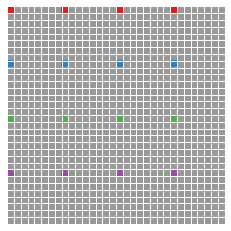

In [98]:
# map = M x M grid where each site has -1 for empty space or the team number of the occupying agent
# agent_dict = dictionary of all agents (initialized, then untouched); 

map, agent_dict, team_scores = initialize()
plot_map(map)

# Simulation

## Pre-populating memory

Do we want pretrain length as a variable input? Right now it's just to fill one batch

In [103]:
map, team_scores = reset(agent_dict)

# Returns true if all experience replays are at max capacity.
def full_mem():
  all_clear = True
  for ind, agnt in agent_dict.items():
    if not agnt.memory.is_full():
      all_clear = False
  return all_clear
    
prepop_turn = 1
agents_to_go_list = []
while prepop_turn < 20000: #not full_mem():
  turn_queue = []
  for ind, agnt in agent_dict.items():
    if agnt.alive() and not agnt.memory.is_full():
      turn_queue.append(ind)
  np.random.shuffle(turn_queue)
  
  if prepop_turn % 1000 == 0:
    print("----Populating memory, turn", prepop_turn, "----")
    agents_to_go_list = []
    for ind, agnt in agent_dict.items():
      if not agnt.memory.is_full():
        agents_to_go_list.append(ind)
    print("Agents to go:", len(agents_to_go_list))
    map, team_scores = reset(agent_dict)

  # Reset map if there is one survivor
  if len(turn_queue) == 1:
    map, team_scores = reset(agent_dict)
    continue
  
  # Loop through alive and non-memory-saturated agents
  for j in turn_queue:   
    # Agent object
    current_agent = agent_dict[j]

    # If already dead, pass turn.
    if not current_agent.alive():
      continue;

    # State formation
    state = current_agent.observe(map)

    # Action selection
    action = np.random.choice(4)    
    if action == 0:                 # North
      dir = np.array([-1,0])
    elif action == 1:               # East
      dir = np.array([0,1])
    elif action == 2:               # West
      dir = np.array([0,-1])
    elif action  == 3:              # South
      dir = np.array([1,0])

    # Take the action
    personal_point,team_point = current_agent.act(dir,prepop_turn, True)

    # New state
    state_new = current_agent.observe(map)

    # Immediate reward
    reward = sigma * personal_point + (1-sigma) * team_point
    
    # Add experience to memory: [s,a,r,s']
    current_agent.memory.add((state, action, reward, state_new))
  
  prepop_turn += 1

print("Memory Population took", prepop_turn, "turns.")

KeyboardInterrupt: ignored

In [108]:
for ind, agnt in agent_dict.items():
  print(agnt.memory.len())

9857
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


## Training

Want to get it working before adding the target network: one step at a time!

In [110]:
#np.random.seed(1)
      

# Training
sess = tf.InteractiveSession() # Initialize session
sess.run(tf.global_variables_initializer())

for i_ep in range(n_ep): # Loop through games
  
  # Reset map and team scores
  map, team_scores = reset(agent_dict)
  
  for turn in range(max_turn):
    turn_queue = action_queue(agent_dict) # Order of taking actions this turn

    # End of game
    if len(turn_queue) == 1:
      print("David", turn_queue[0], "is the lone survivor.")
      print("Team Scores:", team_scores)
      print("Game", str(i_ep), "ended on turn", turn, "-----------------------")
      break

    # Loop through alive agents
    for j in turn_queue:
      # Agent object
      current_agent = agent_dict[j]
      
      # If dead in queue, pass turn.
      if not current_agent.alive():
        continue;

      state = current_agent.observe(map)    # State formation
      
      #action = current_agent.choose_action(state) # Action selection
      q_values = sess.run(current_agent.DQN(state)) # Get q-values from the network
      p_values = tf.exp(beta * q_values)/tf.reduce_sum(tf.exp(beta * q_values)) # Boltzmann probabilities
      action = np.random.choice(np.arange(4),p=p_values.eval())
      
      dir = get_dir(action) # Convert to direction

      # Take the action
      personal_point,team_point = current_agent.act(dir, turn, False)
      
      # New state
      state_new = current_agent.observe(map)

      # Immediate reward
      reward = sigma * personal_point + (1-sigma) * team_point
      
      # Add experience to memory: [s,a,r,s']
      current_agent.memory.add((state, action, reward, state_new))
      
      
      # Update Q-function
      if not current_agent.tenure:
        #current_agent.contemplate(experience_replays[j])
        batch = current_agent.memory.sample(batch_size)

        # Separate out s,a,r,s' from the batch which is a list of lists
        states = np.array([item[0] for item in batch])
        actions = np.array([item[1] for item in batch])
        rewards = np.array([item[2] for item in batch])
        next_states = np.array([item[3] for item in batch])
        '''
        # Reshape (-1 automatically determines the appropriate length)
        states = np.reshape(states,[actual_batch_size, -1])
        actions = np.reshape(actions,[actual_batch_size, -1])
        rewards = np.reshape(rewards,[actual_batch_size, -1])
        next_states = np.reshape(next_states,[actual_batch_size, -1])
        '''
        # Q-value of the next state
        Q_next = sess.run(current_agent.DQN.outputs,
                          feed_dict = {current_agent.DQN.inputs:next_states})

        # Target
        target_Q_batch = []
        for i in len(batch):
          target = rewards[i] + gamma * Q_next[i] #Do we want to apply np.max() to Q_next?
          target_Q_batch.append(target)
        # Not sure if this is necessary, I think it just converts to np.array format?
        targets_Qs = np.array([each for each in target_Q_batch])

        loss, _ = sess.run([current_agent.DQN.loss, current_agent.DQN.optimizer],
                            feed_dict={current_agent.DQN.inputs: states,
                                       current_agent.DQN.target_Q: target_Qs,
                                       current_agent.DQN.actions: actions})
        
        '''
        # Write TF Summaries
        summary = sess.run(write_op, feed_dict={current_agent.DQN.inputs: states,
                                           current_agent.DQN.target_Q: target_Qs
                                           current_agent.DQN.actions: actions})
        writer.add_summary(summary, i_ep)
        writer.flush()
        '''


        '''
        TBD
        # Update target Q-network every some turns
        if (turn+1) % target_copy_freq == 0:
          current_agent.DQN_target = copy.deepcopy(current_agent.DQN)
        '''
    
    # Graphics -----------------------------------------------------------------
    #print("Game " + str(i_ep) + ", turn " + str(turn))
    #plot_map(map)
    #time.sleep(1)
    
    # Game ended without conclusion
    if turn == max_turn-1:
      print("Game", str(i_ep), "ended on turn", turn, "-----------------------")
    
sess.close() # Close session

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


TypeError: ignored